In [195]:
# Standard imports:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [196]:
# Reading the data:

df = pd.read_csv("/content/sample_data/penguins_size.csv")

In [197]:
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [198]:
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [199]:
# Checking for null values:

df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [200]:
# Length of dataset:

len(df)

344

In [201]:
# Removing 10 null rows, which is roughly 2% of dataset (100*(10/344)):

(100*(10/344))

2.9069767441860463

In [202]:
df = df.dropna()

In [203]:
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,FEMALE
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


<Axes: xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

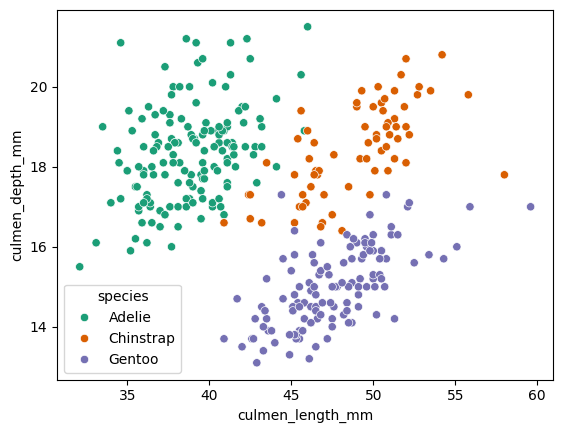

In [204]:
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', data=df, hue='species', palette='Dark2')

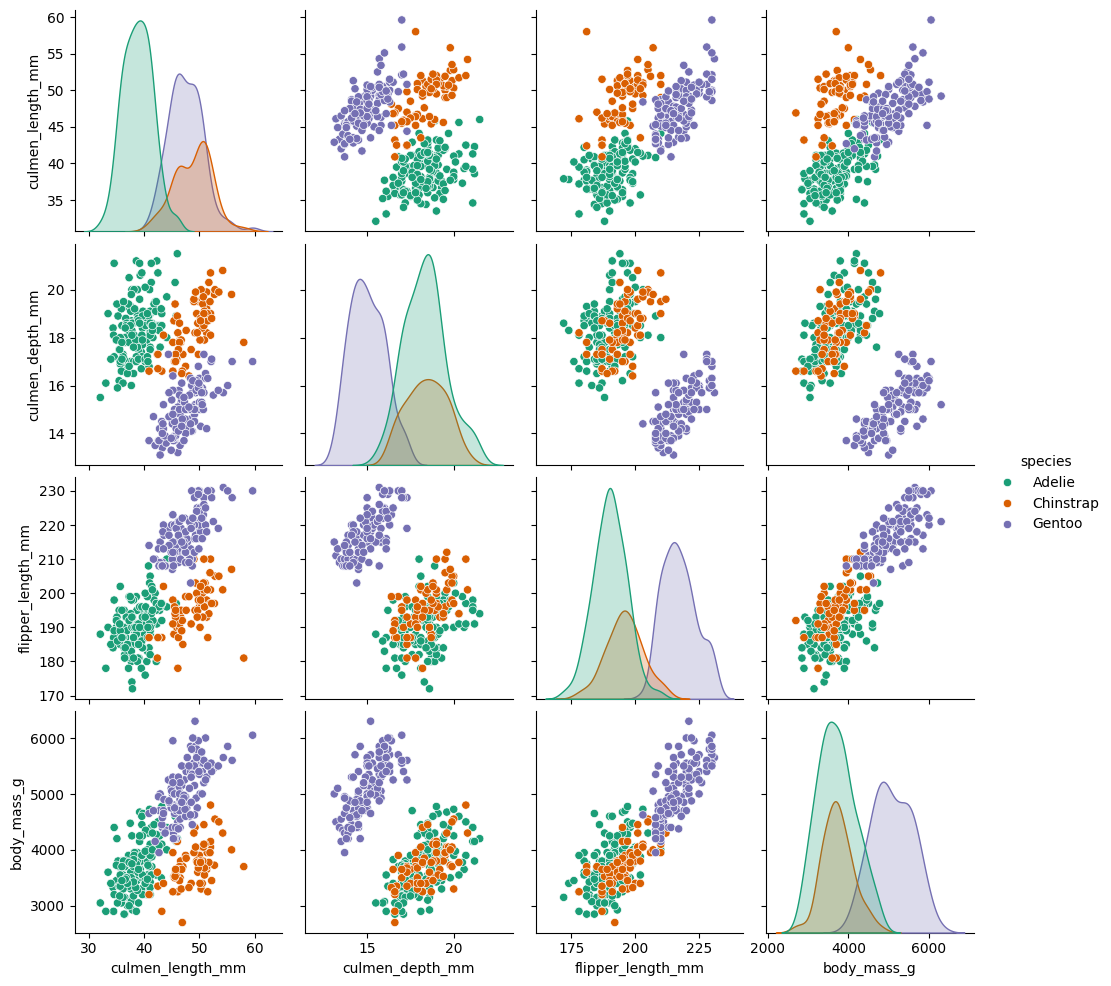

In [205]:
sns.pairplot(df, hue='species', palette='Dark2')

Manually doing one hot encoding, instead of using label or encoders. This is to just avoid too many additional features being created by above methods.

In [206]:
df['species'].replace(['Adelie', 'Chinstrap', 'Gentoo'], [0,1,2], inplace=True)

In [207]:
df['island'].replace(['Torgersen', 'Biscoe', 'Dream'], [0,1,2], inplace=True)

In [208]:
df['sex'].replace(['MALE', 'FEMALE'], [0,1], inplace=True)

In [209]:
df = df[df['sex']!='.']

In [210]:
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,0,39.1,18.7,181.0,3750.0,0
1,0,0,39.5,17.4,186.0,3800.0,1
2,0,0,40.3,18.0,195.0,3250.0,1
4,0,0,36.7,19.3,193.0,3450.0,1
5,0,0,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...,...,...
338,2,1,47.2,13.7,214.0,4925.0,1
340,2,1,46.8,14.3,215.0,4850.0,1
341,2,1,50.4,15.7,222.0,5750.0,0
342,2,1,45.2,14.8,212.0,5200.0,1


In [211]:
# Seperating features vs. Labels:

X = df.drop('species', axis=1)

y = df['species']

In [212]:
# Divinding data into train / test split:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [213]:
# Creating a model instance using emsembles of 10:

model = RandomForestClassifier(n_estimators=10, max_features='auto', random_state=101)

In [214]:
# Fitting the model to the data:

model.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', n_estimators=10, random_state=101)

In [215]:
# Prediction on trained data:

preds = model.predict(X_test)

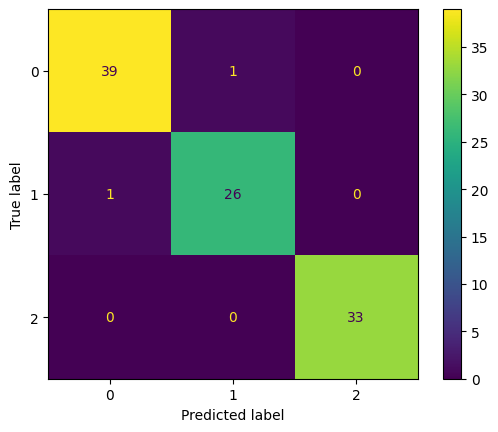

In [216]:
# Confusion Matrix:

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [217]:
# The model is 97% accurate:

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.96      0.96      0.96        27
           2       1.00      1.00      1.00        33

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [218]:
# Checking feature importance, most important being Island at 0.42987622:

model.feature_importances_

array([0.10911408, 0.42987622, 0.17893145, 0.25741063, 0.01848268,
       0.00618493])

In [219]:
# Checking error rate by scaling emsembles:

test_error = []

for n in range(1,40):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n, max_features='auto')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds, y_test))

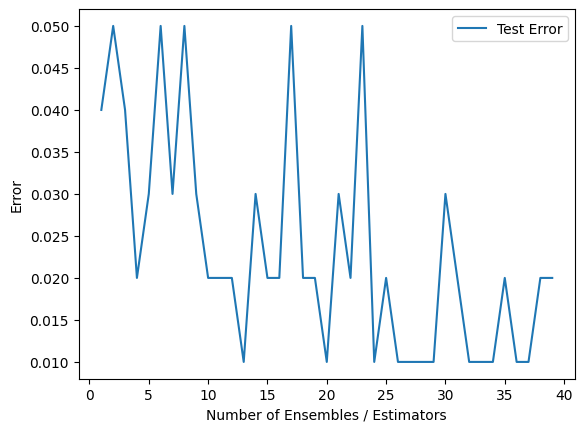

In [220]:
plt.plot(range(1,40), test_error, label='Test Error')
plt.xlabel('Number of Ensembles / Estimators')
plt.ylabel('Error')
plt.legend()

In [221]:
# Search for best parameters using a Grid Search and Cross-validation:

n_estimators=[5,10,64] # Random choice.
max_features= [2,3,4,5,6,7,10,15,20] # Random choice.
bootstrap = [True] # Random selection.
oob_score = [True] # Out of bad error.

In [222]:
#Creating a pipeline:

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score}  # Note, oob_score only makes sense when bootstrap=True!

In [223]:
# Creating an instance of both, RF classifer and Grid Search:

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, param_grid)

In [224]:
# Fitting the new model:

grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True],
                         'max_features': [2, 3, 4, 5, 6, 7, 10, 15, 20],
                         'n_estimators': [5, 10, 64], 'oob_score': [True]})

In [225]:
# Getting the best possible parameters:

grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 10, 'oob_score': True}

We initially started with a randome guess of selecting 10 estimators with RF classifer and number of features as auto. However, as suggested by our grid search, I've retrained the model using the parameters as:

n_estimators=5,  max_features=2,  oob_score=True,  random_state=101

In [226]:
# Re-training using the modified model:

model_opt = RandomForestClassifier(n_estimators=5, max_features=2, oob_score=True, random_state=101)

In [227]:
# Fitting the modified model:

model_opt.fit(X_train, y_train)

RandomForestClassifier(max_features=2, n_estimators=5, oob_score=True,
                       random_state=101)

In [228]:
# Predictions:

preds_opt = model.predict(X_test)

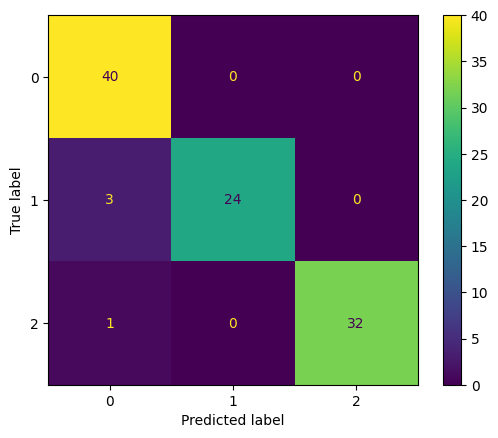

In [229]:
ConfusionMatrixDisplay.from_estimator(model_opt, X_test, y_test)

In [230]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.96      0.96      0.96        27
           2       1.00      1.00      1.00        33

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



This has improved the accuracy from 97% to 98%, while it might not seems a big difference, it is worth noting that this additional improvement was achieved by reducing the features and ensembles space and time complexity.

In [231]:
# Testing row 338 from data:

new = [1, 47.2, 13.7, 214.0, 4925.0, 1]
new = np.array(new).reshape(1,-1) # Converting into a row and an array.

In [232]:
model_opt.predict(new)

array([2])

Correctly classified as class 'Gentoo'